The foreign exchange market has seen significant movement in recent years. The dollar has appreciated in value relative to other currencies, especially compared to the yen. In this article we will use historical data to analyze how the dollar has changed and whether there is a relationship between the dollar and INR and Indian interest rates. The analysis will be conducted using Python.

In [1]:
import os
import re
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
data_dir = "./data/forex_analysis"
os.makedirs(data_dir, exist_ok=True)

In [2]:
business_cycle = pd.read_html(
    "https://www.nber.org/research/data/us-business-cycle-expansions-and-contractions")[0]
# save the data
business_cycle_file_path = f"{data_dir}/business_cycle.csv"
business_cycle.to_csv(business_cycle_file_path, index=False)
business_cycle = pd.read_csv(business_cycle_file_path, header=1)
business_cycle = business_cycle.iloc[1:].reset_index(drop=True)
business_cycle.head(3)

,Peak Month,Peak Year,Peak Quarter,Trough Month,Trough Year,Trough Quarter,Peak to Trough (Months),Previous Trough to this Peak (Months),Trough from Previous Trough (Months),Peak from Previous Peak (Months),Unnamed: 10_level_1
0,June,1857,2,December,1858,4,18,30,48,-,NaN
1,*October,1860,3,*June,1861,3,8,22,30,40,NaN
2,*April,1865,1,*December,1867,Trough occurred 1868Q1,32,46,78,54,NaN


Let’s check the business cycle by drawing a diagram showing periods of recession in gray and periods of expansion in white.

[(datetime.datetime(2001, 3, 1, 0, 0), datetime.datetime(2001, 11, 1, 0, 0)), (datetime.datetime(2007, 12, 1, 0, 0), datetime.datetime(2009, 6, 1, 0, 0)), (datetime.datetime(2020, 2, 1, 0, 0), datetime.datetime(2020, 4, 1, 0, 0))]


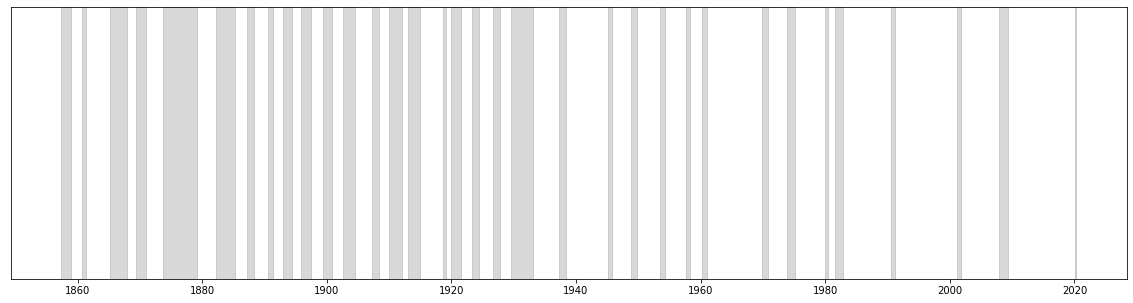

In [3]:
cycle_list = []
for i in range(len(business_cycle)):
    row = business_cycle.iloc[i]
    peak_month = re.sub(r"\*", "", row["Peak Month"])
    peak = dt.datetime.strptime(f"{row['Peak Year']}{peak_month}", "%Y%B")
    trough_month = re.sub(r"\*", "", row["Trough Month"])
    trough = dt.datetime.strptime(f"{row['Trough Year']}{trough_month}", "%Y%B")
    cycle_list.append((peak, trough))
print(cycle_list[-3:])
fig, ax = plt.subplots(figsize=(20, 5))
for x in cycle_list:
    ax.axvspan(x[0], x[1], color="gray", alpha=0.3)
ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
start = dt.datetime(1950, 1, 1)
end = dt.datetime(2022, 9, 30)
inr_to_usd = web.DataReader('DEXINUS', 'fred', start, end)
# save the data
file_path = f"{data_dir}/DEXINUS.csv"
inr_to_usd.to_csv(file_path)
inr_to_usd = pd.read_csv(file_path, index_col="DATE", parse_dates=True)
print(inr_to_usd.shape)
inr_to_usd

(12974, 1)


,DEXINUS
DATE,
1973-01-02,8.02
1973-01-03,8.02
1973-01-04,8.00
1973-01-05,8.01
1973-01-08,8.00
...,...
2022-09-19,79.71
2022-09-20,79.72
2022-09-21,79.96


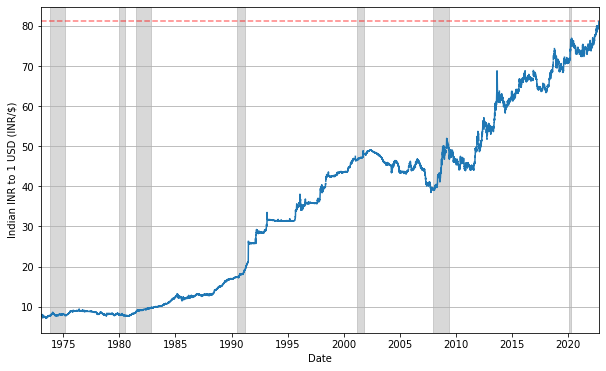

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(inr_to_usd)
plt.hlines(
    inr_to_usd.tail(1),
    inr_to_usd.index[0],
    inr_to_usd.index[-1],
    linestyles="dashed",
    colors="red",
    alpha=0.5,)
for x in cycle_list:
    plt.axvspan(x[0], x[1], color="gray", alpha=0.3)
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("Indian INR to 1 USD (INR/$)")
plt.xlim(inr_to_usd.index[0], inr_to_usd.index[-1])
plt.show()

## US 10Y Bond Yield

In [9]:
treasury = web.DataReader('GS10', 'fred', start, end)
# save the data
file_path = f"{data_dir}/GS10.csv"
treasury.to_csv(file_path)
treasury = pd.read_csv(file_path, index_col="DATE", parse_dates=True)
print(treasury.shape)
treasury = treasury.interpolate()
treasury

(833, 1)


,GS10
DATE,
1953-04-01,2.83
1953-05-01,3.05
1953-06-01,3.11
1953-07-01,2.93
1953-08-01,2.95
...,...
2022-04-01,2.75
2022-05-01,2.90
2022-06-01,3.14


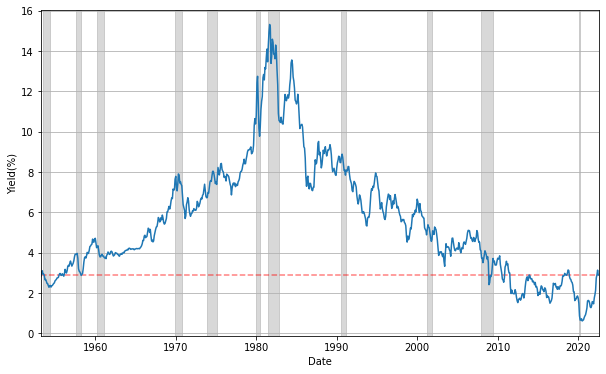

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(treasury)
plt.hlines(
    treasury.tail(1),
    treasury.index[0],
    treasury.index[-1],
    linestyles="dashed",
    colors="red",
    alpha=0.5,)
for x in cycle_list:
    plt.axvspan(x[0], x[1], color="gray", alpha=0.3)
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("Yield(%)")
plt.xlim(treasury.index[0], treasury.index[-1])
plt.show()

## India 10-year Bond Yield

In [11]:
in_bond = web.DataReader('INDIRLTLT01STM', 'fred', start, end)
# save the data
file_path = f"{data_dir}/INDIRLTLT01STM.csv"
in_bond.to_csv(file_path)
in_bond = pd.read_csv(file_path, index_col="DATE", parse_dates=True)
print(in_bond.shape)
in_bond = in_bond.interpolate()
in_bond

(128, 1)


,INDIRLTLT01STM
DATE,
2011-12-01,8.5600
2012-01-01,8.2350
2012-02-01,8.1925
2012-03-01,8.3740
2012-04-01,8.5875
...,...
2022-03-01,6.8200
2022-04-01,7.1100
2022-05-01,7.3900


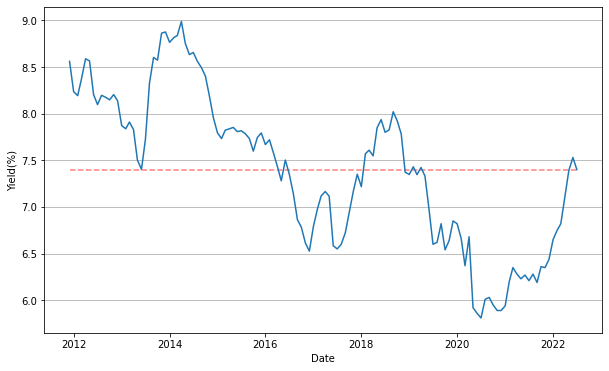

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(in_bond)
plt.hlines(
    in_bond.tail(1),
    in_bond.index[0],
    in_bond.index[-1],
    linestyles="dashed",
    colors="red",
    alpha=0.5,)
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("Yield(%)")
plt.show()

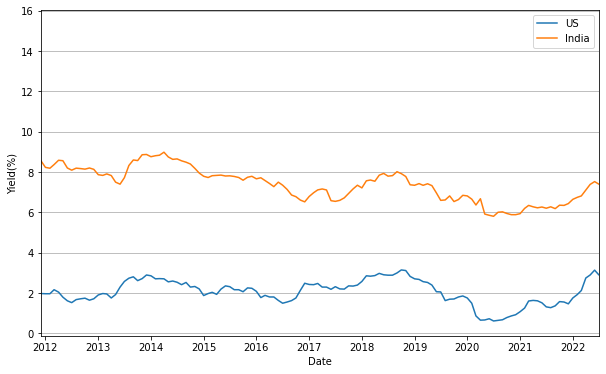

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(treasury, label="US")
plt.plot(in_bond, label="India")
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("Yield(%)")
plt.xlim(in_bond.index[0], in_bond.index[-1])
plt.legend()
plt.show()

## The relationship between the U.S.-India interest rate differential and the exchange rate

We will analyze how interest rates in India and the U.S. relate to the exchange rate. First, we will compare bond yields in both countries.

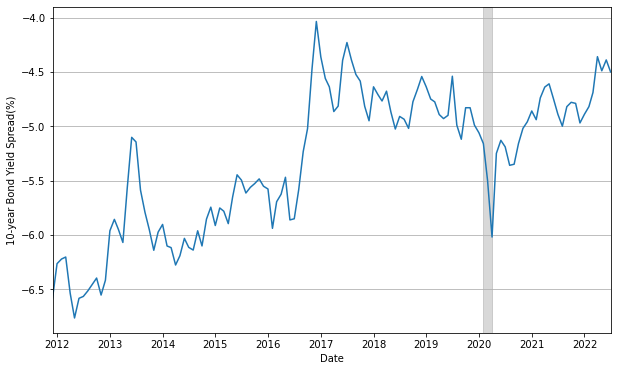

In [14]:
df = in_bond.join(treasury)
df["Treasury-IndBond"] = df["GS10"] - df["INDIRLTLT01STM"]
plt.figure(figsize=(10, 6))
plt.plot(df[["Treasury-IndBond"]])
for x in cycle_list:
    plt.axvspan(x[0], x[1], color="gray", alpha=0.3)
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("10-year Bond Yield Spread(%)")
plt.xlim(in_bond.index[0], in_bond.index[-1])
plt.show()

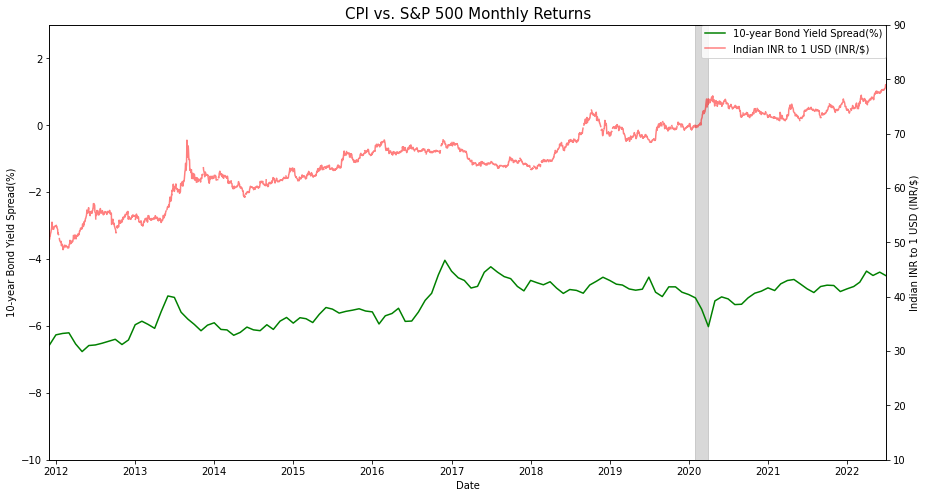

In [20]:
fig, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()
ax1.plot(df[["Treasury-IndBond"]],
         color="green", label="10-year Bond Yield Spread(%)")
ax2.plot(inr_to_usd, color="red", alpha=0.5, label="Indian INR to 1 USD (INR/$)")
for x in cycle_list:
    ax1.axvspan(x[0], x[1], color="gray", alpha=0.3)
plt.tick_params(labelsize=10)  # font size of tick labels
plt.title("CPI vs. S&P 500 Monthly Returns", fontsize=15)
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc=1, borderaxespad=0.)
ax1.set_xlabel("Date")
ax1.set_ylabel("10-year Bond Yield Spread(%)")
ax2.set_ylabel("Indian INR to 1 USD (INR/$)")
ax1.set_ylim([-10, 3])
ax2.set_ylim([10, 90])
ax1.set_xlim(in_bond.index[0], in_bond.index[-1])
plt.show()


Excellent! We can see that when the interest rate differential increases, that is, when the outlook for the U.S. economy is good, the dollar basically appreciates. Conversely, the INR appreciates when the U.S. is in boom or when the economic outlook is good.

(12089, 1)


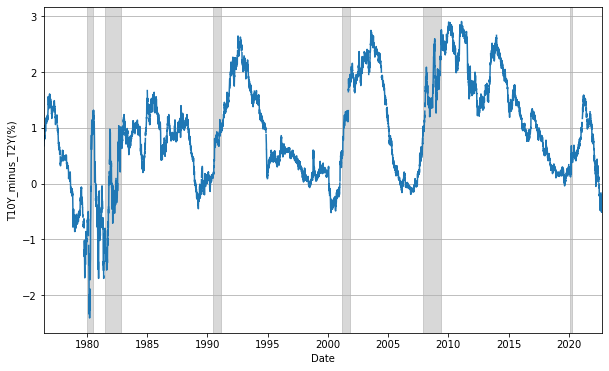

In [17]:
T10Y_minus_T2Y = web.DataReader('T10Y2Y', 'fred', start, end)
# save the data
file_path = f"{data_dir}/T10Y2Y.csv"
T10Y_minus_T2Y.to_csv(file_path)
T10Y_minus_T2Y = pd.read_csv(file_path, index_col="DATE", parse_dates=True)
print(T10Y_minus_T2Y.shape)
plt.figure(figsize=(10, 6))
plt.plot(T10Y_minus_T2Y)
for x in cycle_list:
    plt.axvspan(x[0], x[1], color="gray", alpha=0.3)
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("T10Y_minus_T2Y(%)")
plt.xlim(T10Y_minus_T2Y.index[0], T10Y_minus_T2Y.index[-1])
plt.show()


## When Will the Next Recession Come?


Currently, the U.S. economy is strong, the interest rate differential is expanding, and the dollar is appreciating. However, there is a possibility that the yen will depreciate if the U.S. enters a recession. So when will the U.S. enter a recession?

One indicator to find out is the difference between short- and long-term interest rates. We will download and plot the data for the yield on the U.S. 10-year Treasury note minus the yield on the U.S. 2-year Treasury note.